<a href="https://colab.research.google.com/github/rmeinl/waste_bag_classifier/blob/master/recycleye.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
Develop waste bag classifier.

Assumptions
- The camera is fixed in place and will not move.
- There could be multiple objects/bags in an image.
- They will not overlap/ they will be spaced.

# Strategy

1. Defining the Problem 
- for a given set of images, build a model which can classify the different types of waste bags (out of three classes) in each image
- Is this a Problem that can be solved with Machine Learning? If yes, continue

---
2. Measure of Success

Questions:
- What is the higher level business goal that we are trying to achieve? (e.g. costs or man hours saved)

- once that is clear, we will want to find a proxy metric for our offline testing which is quantitative and can be measured 
- Dataset distribution is well balanced, so can use Accuracy
  - general_waste: 108
  - mixed_recycling: 106
  - green_sack: 92
- If it would be imbalanced, Precision and Recall would be more appropriate

---
3. Evaluation Protocol
- if we had more data (500k+) we could split our dataset into train, validation and test and train the model on the training set, tune our hyperparameters on validation and report results on test set
- we have extremely little data: Use K-fold validation or Iterated K-fold validation (repeat K-fold validation m times and take average)

---
4. Data Preparation
- normalize data
- data augmentation (could be helpful with our small dataset)
- feature engineering (not necessarily relevant with deep learning but might make sense because our dataset is so small)

---
5. Develop a model better than a dumb statistical baseline or even a human baseline
- reassurance that ML is useful here

---
6. Develop a model that overfits
- add (bigger) layers, train longer, use bigger model
- observe Bias-Variance tradeoff

---
7. Apply regularization methods and tune hyperparameters
- dropout, different architectures, more data, regularization methods

# Setting up GDrive

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
!ls "/content/drive/My Drive/Recycleye"

general_waste  green_sack  mixed_recycling  notebook


# Installing Torch

In [71]:
!pip3 install torch torchvision -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [139]:
!pip3 install opencv-python

In [72]:
import torch
import torchvision
torch.version.__version__

'1.5.1+cu101'

In [92]:
import copy
import time

import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder, DatasetFolder
from torchvision import models
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset, Subset, Dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold, train_test_split
from sklearn.preprocessing import OneHotEncoder

# Inspecting the data
- very small dataset (only about 150 images) 
- the .npy files look like depth maps taken from the phones rear camera
- only contain one bag (one class) per images

In [74]:
def my_numpy_loader(filename):
  np_arr = np.load(filename, allow_pickle=True).astype(np.float32)
  np_arr *= 255.0/np_arr.max()
  # cutoff = 200.0
  # np_arr[np_arr>cutoff] = 255
  # np_arr[np_arr<=cutoff] = 0
  return np_arr.astype(np.int32)

In [75]:
print("Data Class Distribution")
! ls "/content/drive/My Drive/Recycleye/general_waste" | wc -l
! ls "/content/drive/My Drive/Recycleye/mixed_recycling" | wc -l
! ls "/content/drive/My Drive/Recycleye/green_sack" | wc -l

Data Class Distribution
108
106
92


In [76]:
image_transforms = {
    "train": None,
    "test": transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = "/content/drive/My Drive/Recycleye/notebook"
image_datasets = {x: ImageFolder(root=f"{data_dir}/{x}", transform=image_transforms[x])
                  for x in ['train', 'test']}
np_datasets = {x: DatasetFolder(root=f"{data_dir}/{x}", loader=my_numpy_loader, 
                            transform=transforms.ToTensor(), extensions='.npy')
                  for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

In [77]:
image_loaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True)
                for x in ['train', 'test']}
np_loaders = {x: DataLoader(np_datasets[x], batch_size=4, shuffle=True)
                for x in ['train', 'test']}

In [78]:
class_names

['general_waste', 'green_sack', 'mixed_recycling']

In [79]:
def imshow(inp, title=None, is_image=True):
    """Imshow for Tensor."""
    fig, ax = plt.subplots(figsize=(16, 4))
    inp = inp.numpy().transpose((1, 2, 0))
    if is_image:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

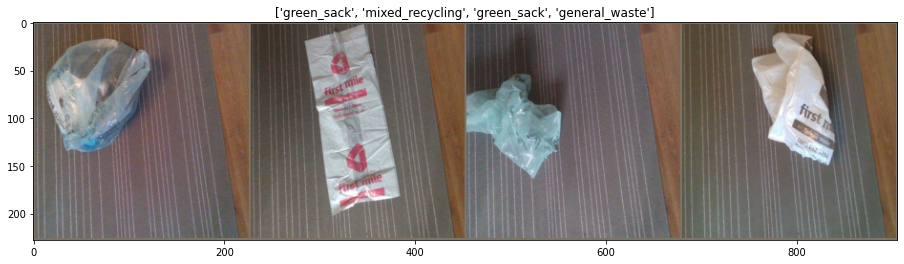

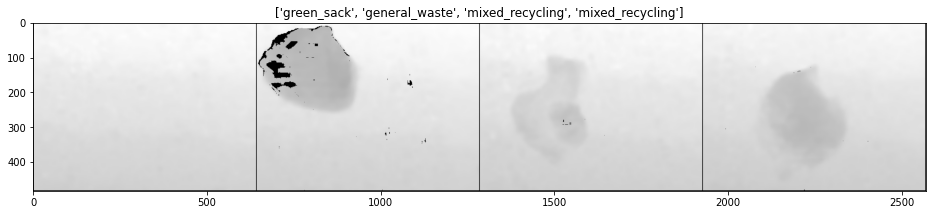

In [80]:
# Get a batch of image data
inputs, classes = next(iter(image_loaders["test"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes], is_image=True)

# Get a batch of numpy data
inputs, classes = next(iter(np_loaders["test"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes], is_image=False)

## Baseline Model

In [81]:
dumb_baseline_prediction = torch.tensor([0], dtype=torch.int32)    # always predicts class 0
correct = 0
total = 0

for inputs, labels in image_loaders["test"]:
    output = dumb_baseline_prediction.expand(labels.shape[0])
    total += labels.size(0)
    correct += (output == labels).float().sum().item()
    # if we had to do accuracy for multiple labels in one image
    # correct = (np.count_nonzero(y_test - y_pred, axis=1) == 0).sum()

print(f'Accuracy of a baseline on the {total} test images: {100 * correct / total}')

Accuracy of a baseline on the 37 test images: 35.13513513513514


## First Model to beat the Baseline

In [82]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [83]:
#@title
#@Credits: https://gist.github.com/stefanonardo/693d96ceb2f531fa05db530f3e21517d

class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if torch.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [84]:
def get_model():
    n_classes = 3

    model = models.vgg11_bn(pretrained=True)
    # Freeze model weights
    for param in model.parameters():
        param.requires_grad = False

    num_features = model.classifier[6].in_features
    # model.classifier[6] = nn.Linear(num_features, n_classes)
    model.classifier[6] = nn.Sequential(
                                nn.Linear(num_features, 256), 
                                nn.ReLU(), 
                                nn.Dropout(0.4),
                                nn.Linear(256, n_classes))
                                # nn.ReLU(), 
                                # nn.Dropout(0.4),
                                # nn.Linear(64, n_classes))

    return model

In [85]:
summary(get_model().to(device), input_size = (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5        [-1, 128, 112, 112]          73,856
       BatchNorm2d-6        [-1, 128, 112, 112]             256
              ReLU-7        [-1, 128, 112, 112]               0
         MaxPool2d-8          [-1, 128, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         295,168
      BatchNorm2d-10          [-1, 256, 56, 56]             512
             ReLU-11          [-1, 256, 56, 56]               0
           Conv2d-12          [-1, 256, 56, 56]         590,080
      BatchNorm2d-13          [-1, 256, 56, 56]             512
             ReLU-14          [-1, 256,

In [86]:
def plot_history(train_hist, val_hist, plot_type):
    plt.rcParams["figure.figsize"] = (20,10)
    # train_hist = [h.cpu().numpy() for h in train_hist]
    # val_hist = [h.cpu().numpy() for h in val_hist]
    num_epochs = len(train_hist)

    plt.title(f"{plot_type} vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel(plot_type)
    plt.plot(range(1,num_epochs+1),train_hist,label="Train")
    plt.plot(range(1,num_epochs+1),val_hist,label="Val")
    plt.ylim((0,1.5))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()

In [87]:
class WrapperDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        image, label = self.subset[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.subset)

In [88]:
onthefly_transforms = {
    "train": transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ColorJitter(brightness=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

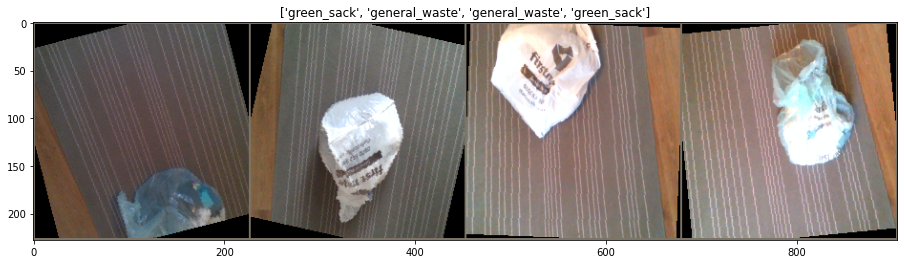

In [56]:
# Test the data augmentation
test_transform = WrapperDataset(subset=Subset(image_datasets["train"], np.arange(dataset_sizes["train"])), 
                              transform=onthefly_transforms["train"]
        )
test_loader = DataLoader(test_transform, shuffle=True, num_workers=4, batch_size=4)

# Get a batch of image data
inputs, classes = next(iter(test_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes], is_image=True)

In [89]:
def train_model(dataset, image_transforms, learning_rate, num_epochs=25):
    start_time = time.time()

    rkf = RepeatedKFold(n_splits=3, n_repeats=1, random_state=42)

    best_acc = 0.0

    for i, (train_indices, valid_indices) in enumerate(rkf.split(dataset)):
        model = get_model()
        model.to(device)
        best_model_wts = copy.deepcopy(model.state_dict())

        # would be needed for multilabel classification
        # criterion = torch.nn.BCEWithLogitsLoss()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.classifier[6].parameters(), 
                                    lr=learning_rate, 
                                    momentum=0.9)
      
        # x_train_fold = torch.tensor(x_train[train_index])
        # y_train_fold = torch.tensor(y_train[train_index, np.newaxis])
        # x_valid_fold = torch.tensor(x_train[valid_index])
        # y_valid_fold = torch.tensor(y_train[valid_index, np.newaxis])
        # train = TensorDataset(x_train_fold, y_train_fold)
        # valid = TensorDataset(x_valid_fold, y_valid_fold)
        train = WrapperDataset(subset=Subset(dataset, train_indices), 
                              transform=image_transforms["train"]
        )
        valid = WrapperDataset(subset=Subset(dataset, valid_indices), 
                              transform=image_transforms["val"]
        )

        dataset_sizes = {
            "train": len(train),
            "val": len(valid)
        }

        dataloaders = {
            # "train": DataLoader(train, shuffle=True, num_workers=4),
            # "val": DataLoader(valid, shuffle=False, num_workers=4)
            "train": DataLoader(train, batch_size=4, shuffle=True, num_workers=4),
            "val": DataLoader(valid, batch_size=4, shuffle=False, num_workers=4)
        }

        print(f'Fold {i + 1}')

        train_acc_history = []
        train_loss_history = []
        val_acc_history = []
        val_loss_history = []

        # loss_acc_history_dict = {}
        early_stopping = EarlyStopping(patience=15, mode='max')
      
        for epoch in range(num_epochs):
            if epoch % 5 == 0:
                    print('Epoch {}/{}'.format(epoch+1, num_epochs))
                    print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    # labels = torch.squeeze(labels, dim=0)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        # preds = (outputs>0.5).float()
                        loss = criterion(outputs, labels)
                        
                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                        
                    running_loss += loss.item() * inputs.size(0)
                    # would have to use this for multilabel classification
                    # running_corrects += ((labels-preds).sum(dim=1) == 0).double().sum()
                    running_corrects += torch.sum(preds == labels.data)
              
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                if epoch % 5 == 0:
                    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                            phase, epoch_loss, epoch_acc))

                if phase == 'train':
                    train_loss_history.append(epoch_loss)
                    train_acc_history.append(epoch_acc)
                if phase == 'val':
                    val_loss_history.append(epoch_loss)
                    val_acc_history.append(epoch_acc)

                    if epoch_acc > best_acc:
                        # deep copy the model
                        print(f"New best accuracy: {epoch_acc}. Copying model...")
                        best_acc = epoch_acc
                        best_model_wts = copy.deepcopy(model.state_dict())
            
            if early_stopping.step(val_acc_history[-1]):
                break  # early stop criterion is met, we can stop now

        plot_history(train_loss_history, val_loss_history, plot_type="Loss")
        plot_history(train_acc_history, val_acc_history, plot_type="Accuracy")

        # loss_acc_history_dict[i] = {
        #     "train": {
        #         "loss": train_loss_history,
        #         "acc": train_acc_history
        #     },
        #     "val": {
        #         "loss": val_loss_history,
        #         "acc": val_acc_history
        #     }
        # }

    time_elapsed = time.time() - start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

Fold 1
Epoch 1/50
----------
train Loss: 1.1282 Acc: 0.2222
val Loss: 1.0397 Acc: 0.5405
New best accuracy: 0.5405405405405406. Copying model...
New best accuracy: 0.5675675675675675. Copying model...
New best accuracy: 0.6756756756756757. Copying model...
New best accuracy: 0.7027027027027027. Copying model...
Epoch 6/50
----------
train Loss: 0.7290 Acc: 0.7917
val Loss: 0.7543 Acc: 0.7027
New best accuracy: 0.7297297297297298. Copying model...
New best accuracy: 0.8108108108108109. Copying model...
Epoch 11/50
----------
train Loss: 0.5441 Acc: 0.7500
val Loss: 0.5536 Acc: 0.7568
New best accuracy: 0.8918918918918919. Copying model...
Epoch 16/50
----------
train Loss: 0.4418 Acc: 0.8194
val Loss: 0.4805 Acc: 0.8649
Epoch 21/50
----------
train Loss: 0.5025 Acc: 0.7917
val Loss: 0.5134 Acc: 0.8108
Epoch 26/50
----------
train Loss: 0.3673 Acc: 0.8750
val Loss: 0.4375 Acc: 0.8919
New best accuracy: 0.918918918918919. Copying model...
Epoch 31/50
----------
train Loss: 0.3563 Acc: 0.9

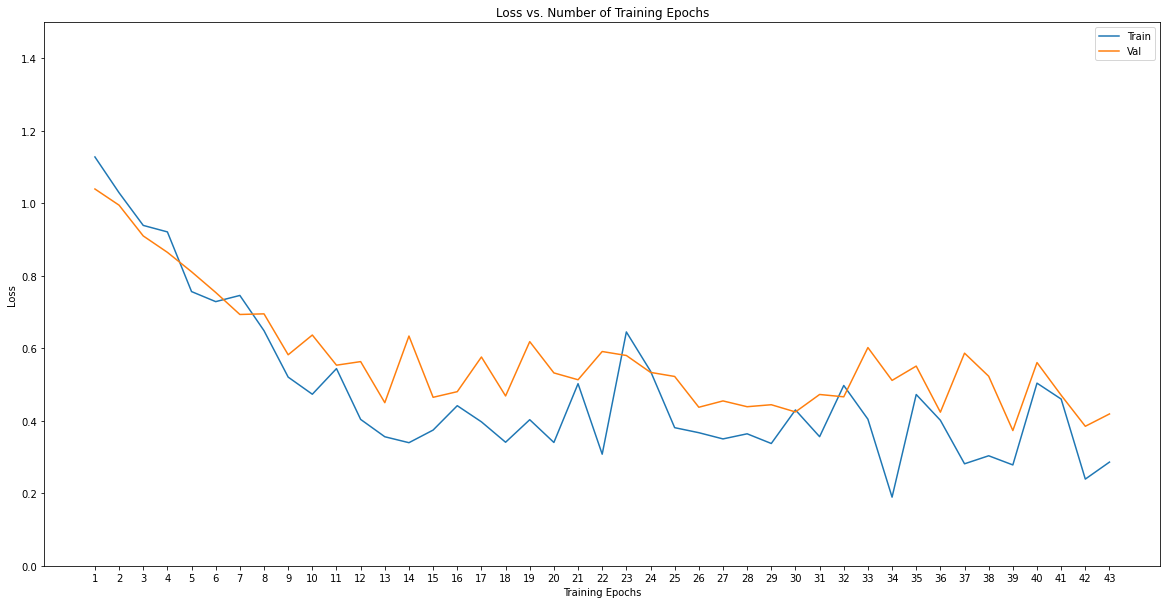

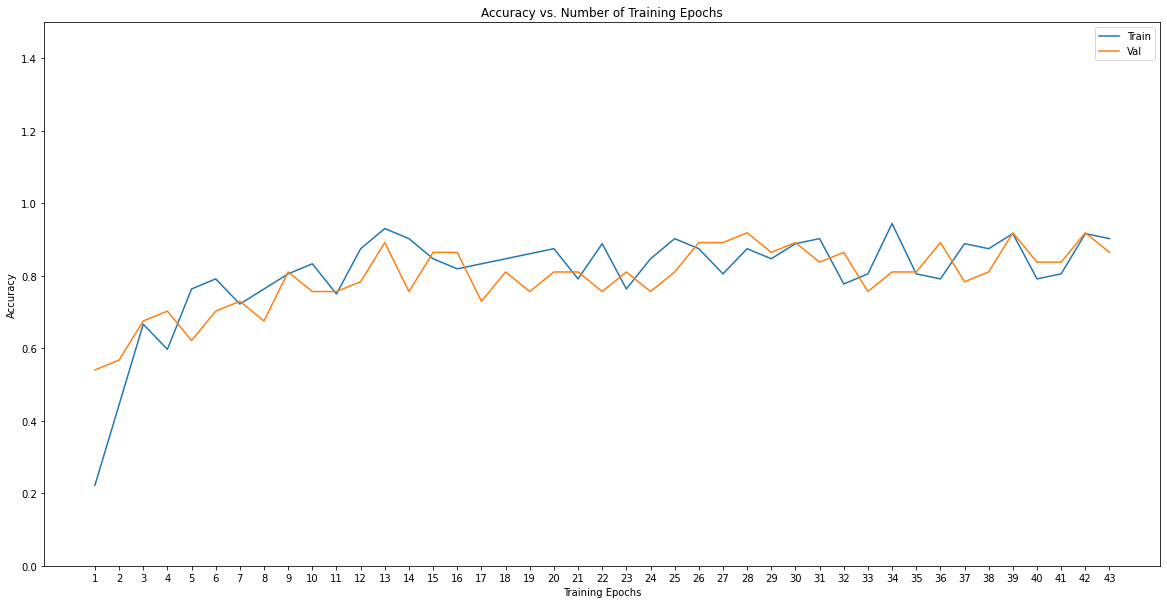

Fold 2
Epoch 1/50
----------
train Loss: 1.0915 Acc: 0.3562
val Loss: 1.0179 Acc: 0.7222
Epoch 6/50
----------
train Loss: 0.6983 Acc: 0.7260
val Loss: 0.6219 Acc: 0.8333
Epoch 11/50
----------
train Loss: 0.5780 Acc: 0.7671
val Loss: 0.3380 Acc: 0.9167
Epoch 16/50
----------
train Loss: 0.5059 Acc: 0.8082
val Loss: 0.4266 Acc: 0.8056
Epoch 21/50
----------
train Loss: 0.5056 Acc: 0.7808
val Loss: 0.2164 Acc: 0.9167
New best accuracy: 0.9444444444444444. Copying model...
Epoch 26/50
----------
train Loss: 0.3994 Acc: 0.8493
val Loss: 0.5232 Acc: 0.6667
Epoch 31/50
----------
train Loss: 0.3346 Acc: 0.8493
val Loss: 0.3341 Acc: 0.8056
Epoch 36/50
----------
train Loss: 0.3654 Acc: 0.8356
val Loss: 0.2278 Acc: 0.9167


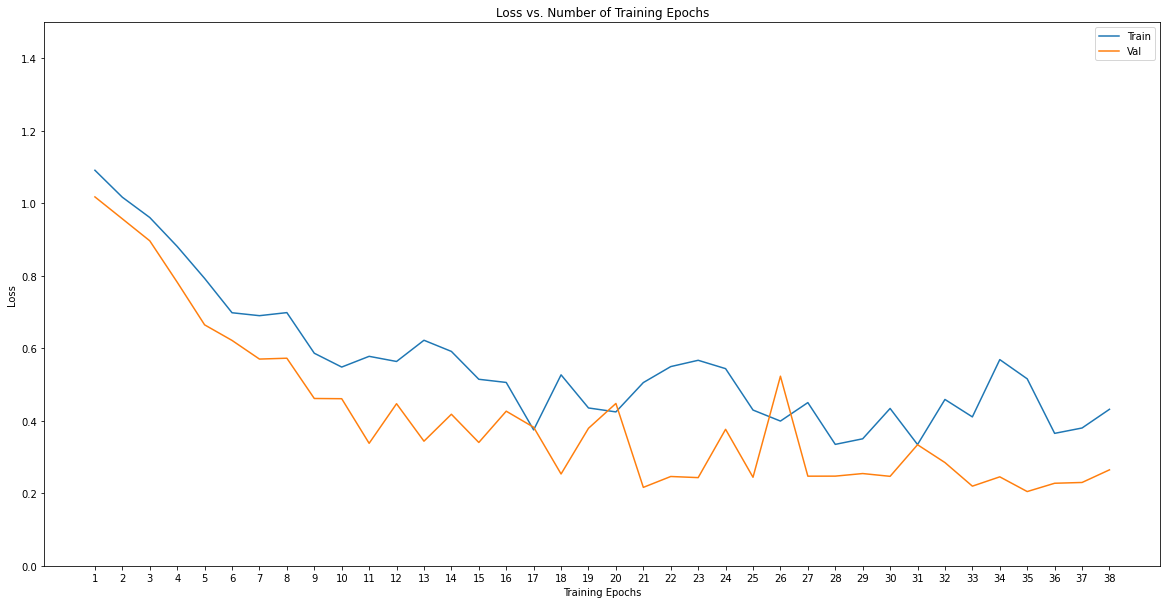

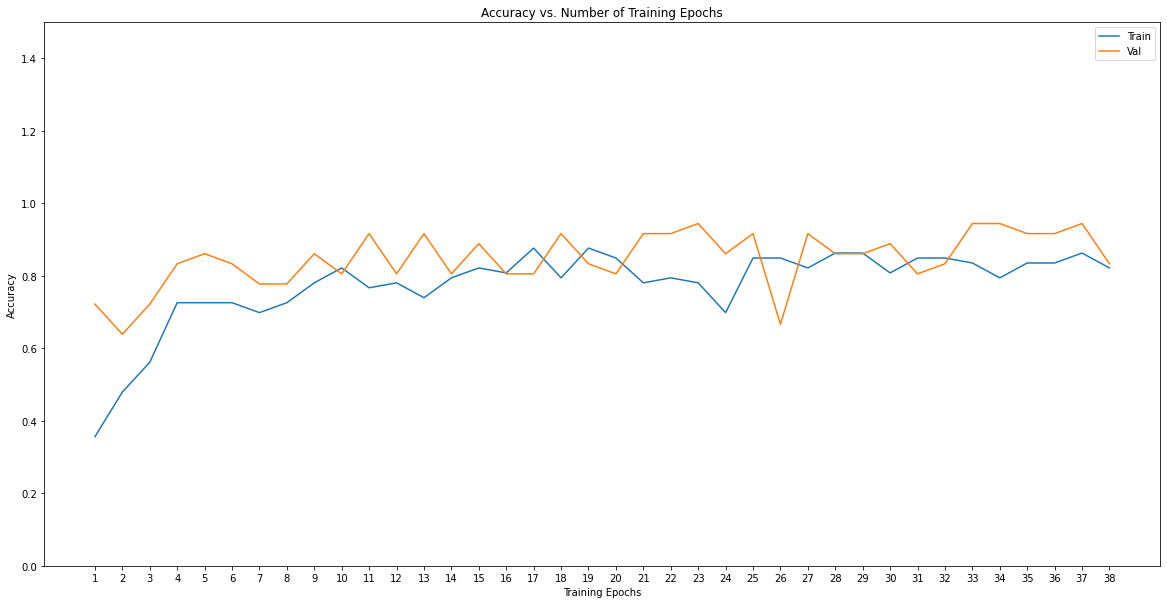

Fold 3
Epoch 1/50
----------
train Loss: 1.0652 Acc: 0.4384
val Loss: 1.0354 Acc: 0.8611
Epoch 6/50
----------
train Loss: 0.9050 Acc: 0.6438
val Loss: 0.6841 Acc: 0.9722
New best accuracy: 0.9722222222222222. Copying model...
Epoch 11/50
----------
train Loss: 0.5454 Acc: 0.8219
val Loss: 0.3498 Acc: 0.9722
Epoch 16/50
----------
train Loss: 0.5883 Acc: 0.7123
val Loss: 0.2166 Acc: 0.9444
New best accuracy: 1.0. Copying model...
Epoch 21/50
----------
train Loss: 0.4335 Acc: 0.8493
val Loss: 0.1467 Acc: 0.9444
Epoch 26/50
----------
train Loss: 0.4466 Acc: 0.7808
val Loss: 0.0860 Acc: 0.9722
Epoch 31/50
----------
train Loss: 0.6695 Acc: 0.6575
val Loss: 0.0635 Acc: 1.0000


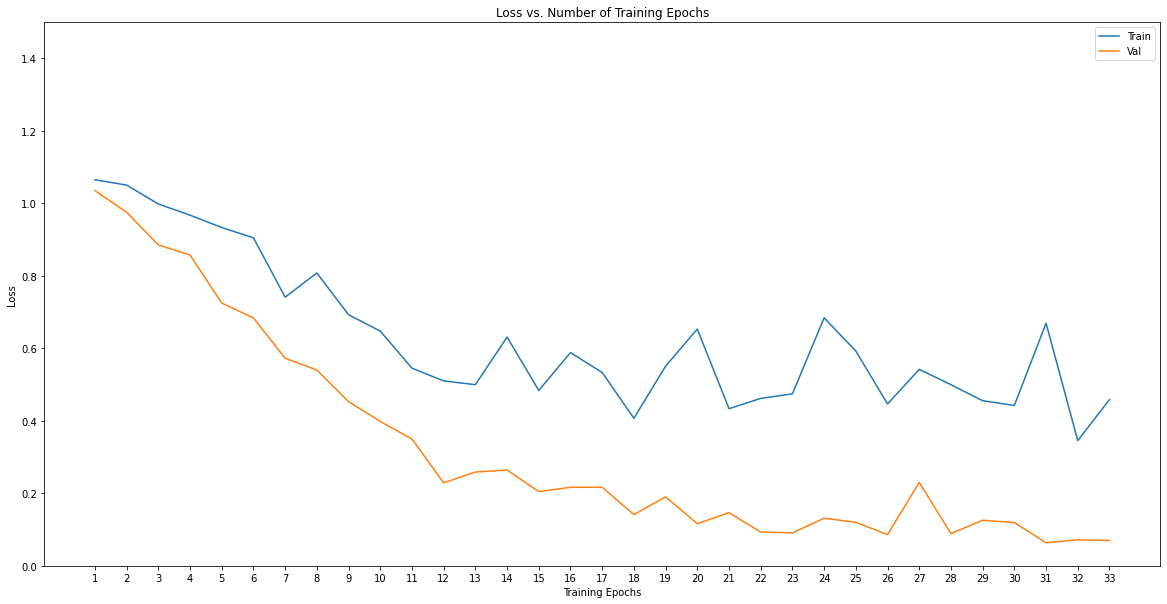

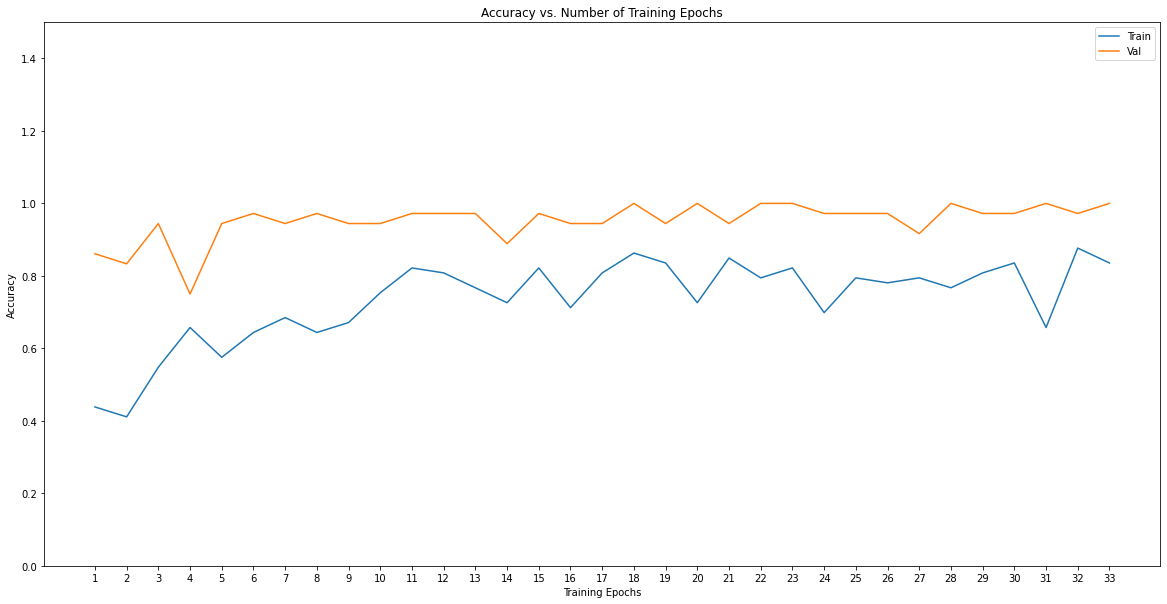

Training complete in 4m 46s
Best val Acc: 1.000000


In [90]:
model = train_model(dataset=image_datasets["train"], 
                    image_transforms=onthefly_transforms,
                    learning_rate=0.001, 
                    num_epochs=50)

In [95]:
# Evaluate the model on our test set
# To Beat: Dumb Baseline Accuracy of 0.3514
correct = 0
total = 0
list_labels = []
list_preds = []

with torch.no_grad():
    for inputs, labels in image_loaders["test"]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        output = model(inputs)
        _, preds = torch.max(output, 1)
        total += labels.size(0)
        correct += torch.sum(preds == labels).item()
        # if we had to do accuracy for multiple labels in one image
        # correct = (np.count_nonzero(y_test - y_pred, axis=1) == 0).sum()
        list_labels.extend(list(labels.cpu().numpy()))
        list_preds.extend(list(preds.cpu().numpy()))

print(f'Accuracy of the VGG on the {total} test images: {100 * correct / total}')

Accuracy of the VGG on the 37 test images: 89.1891891891892


In [98]:
cm = confusion_matrix(list_labels, list_preds)

In [97]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


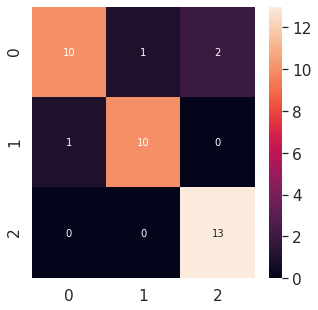

In [108]:
plt.rcParams["figure.figsize"] = (5,5)
sns.heatmap(cm, annot=True, annot_kws={"size": 10}) # font size

# Visualize Predictions

In [122]:
def visualize_model(model):
    was_training = model.training
    model.eval()

    with torch.no_grad():
        inputs, labels = next(iter(image_loaders["test"]))
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Make a grid from batch
        out = torchvision.utils.make_grid(inputs.cpu())

        imshow(out, title=[class_names[x] for x in classes], is_image=True)

    model.train(mode=was_training)

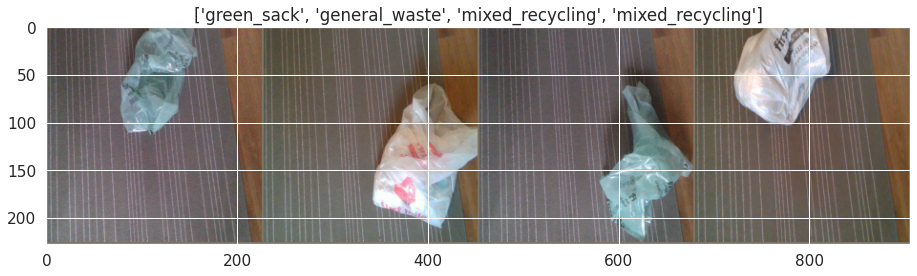

In [123]:
visualize_model(model)

# Visualize Activations

In [172]:
#@title
#@Credits: https://github.com/yiskw713/ScoreCAM
from statistics import mode, mean
import cv2

def reverse_normalize(x, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    x[:, 0, :, :] = x[:, 0, :, :] * std[0] + mean[0]
    x[:, 1, :, :] = x[:, 1, :, :] * std[1] + mean[1]
    x[:, 2, :, :] = x[:, 2, :, :] * std[2] + mean[2]
    # x = x.numpy().transpose((1, 2, 0))
    # x = std * x + mean
    # x = x.clip(x, 0, 1)
    return x


def visualize(img, cam):
    """
    Synthesize an image with CAM to make a result image.
    Args:
        img: (Tensor) shape => (1, 3, H, W)
        cam: (Tensor) shape => (1, 1, H', W')
    Return:
        synthesized image (Tensor): shape =>(1, 3, H, W)
    """

    _, _, H, W = img.shape
    cam = F.interpolate(cam, size=(H, W), mode='bilinear', align_corners=False)
    cam = 255 * cam.squeeze()
    heatmap = cv2.applyColorMap(np.uint8(cam), cv2.COLORMAP_JET)
    heatmap = torch.from_numpy(heatmap.transpose(2, 0, 1))
    heatmap = heatmap.float() / 255
    b, g, r = heatmap.split(1)
    heatmap = torch.cat([r, g, b])

    result = heatmap + img.cpu()
    result = result.div(result.max())

    return result

class SaveValues():
    def __init__(self, m):
        # register a hook to save values of activations and gradients
        self.activations = None
        self.gradients = None
        self.forward_hook = m.register_forward_hook(self.hook_fn_act)
        self.backward_hook = m.register_backward_hook(self.hook_fn_grad)

    def hook_fn_act(self, module, input, output):
        self.activations = output

    def hook_fn_grad(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def remove(self):
        self.forward_hook.remove()
        self.backward_hook.remove()

class CAM(object):
    """ Class Activation Mapping """

    def __init__(self, model, target_layer):
        """
        Args:
            model: a base model to get CAM which have global pooling and fully connected layer.
            target_layer: conv_layer before Global Average Pooling
        """

        self.model = model
        self.target_layer = target_layer

        # save values of activations and gradients in target_layer
        self.values = SaveValues(self.target_layer)

    def forward(self, x, idx=None):
        """
        Args:
            x: input image. shape =>(1, 3, H, W)
        Return:
            heatmap: class activation mappings of the predicted class
        """

        # object classification
        score = self.model(x)

        prob = F.softmax(score, dim=1)

        if idx is None:
            prob, idx = torch.max(prob, dim=1)
            idx = idx.item()
            prob = prob.item()
            print("predicted class ids {}\t probability {}".format(idx, prob))

        # cam can be calculated from the weights of linear layer and activations
        weight_fc = list(
            self.model._modules.get('fc').parameters())[0].to('cpu').data

        cam = self.getCAM(self.values, weight_fc, idx)

        return cam, idx

    def __call__(self, x):
        return self.forward(x)

    def getCAM(self, values, weight_fc, idx):
        '''
        values: the activations and gradients of target_layer
            activations: feature map before GAP.  shape => (1, C, H, W)
        weight_fc: the weight of fully connected layer.  shape => (num_classes, C)
        idx: predicted class id
        cam: class activation map.  shape => (1, num_classes, H, W)
        '''

        cam = F.conv2d(values.activations, weight=weight_fc[:, :, None, None])
        _, _, h, w = cam.shape

        # class activation mapping only for the predicted class
        # cam is normalized with min-max.
        cam = cam[:, idx, :, :]
        cam -= torch.min(cam)
        cam /= torch.max(cam)
        cam = cam.view(1, 1, h, w)

        return cam.data

class ScoreCAM(CAM):
    """ Score CAM """

    def __init__(self, model, target_layer, n_batch=32):
        super().__init__(model, target_layer)
        """
        Args:
            model: a base model
            target_layer: conv_layer you want to visualize
        """
        self.n_batch = n_batch

    def forward(self, x, idx=None):
        """
        Args:
            x: input image. shape =>(1, 3, H, W)
            idx: the index of the target class
        Return:
            heatmap: class activation mappings of predicted classes
        """

        with torch.no_grad():
            _, _, H, W = x.shape
            device = x.device

            self.model.zero_grad()
            score = self.model(x)
            prob = F.softmax(score, dim=1)

            if idx is None:
                p, idx = torch.max(prob, dim=1)
                idx = idx.item()
                # print("predicted class ids {}\t probability {}".format(idx, p))

            # # calculate the derivate of probabilities, not that of scores
            # prob[0, idx].backward(retain_graph=True)

            self.activations = self.values.activations.to('cpu').clone()
            # put activation maps through relu activation
            # because the values are not normalized with eq.(1) without relu.
            self.activations = F.relu(self.activations)
            self.activations = F.interpolate(
                self.activations, (H, W), mode='bilinear')
            _, C, _, _ = self.activations.shape

            # normalization
            act_min, _ = self.activations.view(1, C, -1).min(dim=2)
            act_min = act_min.view(1, C, 1, 1)
            act_max, _ = self.activations.view(1, C, -1).max(dim=2)
            act_max = act_max.view(1, C, 1, 1)
            denominator = torch.where(
                (act_max - act_min) != 0., act_max - act_min, torch.tensor(1.)
            )

            self.activations = self.activations / denominator

            # generate masked images and calculate class probabilities
            probs = []
            for i in range(0, C, self.n_batch):
                mask = self.activations[:, i:i+self.n_batch].transpose(0, 1)
                mask = mask.to(device)
                masked_x = x * mask
                score = self.model(masked_x)
                probs.append(F.softmax(score, dim=1)[:, idx].to('cpu').data)

            probs = torch.stack(probs)
            weights = probs.view(1, C, 1, 1)

            # shape = > (1, 1, H, W)
            cam = (weights * self.activations).sum(1, keepdim=True)
            cam = F.relu(cam)
            cam -= torch.min(cam)
            cam /= torch.max(cam)

        return cam.data, idx

    def __call__(self, x):
        return self.forward(x)

In [204]:
def show_activations(inp, cam, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.imshow(cam, alpha=0.4, cmap='jet')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [201]:
# the target layer you want to visualize
target_layer = model.features[25]

wrapped_model = ScoreCAM(model, target_layer)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


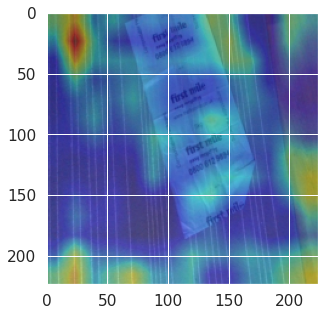

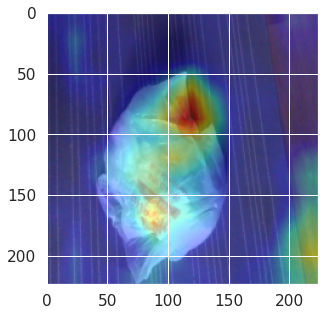

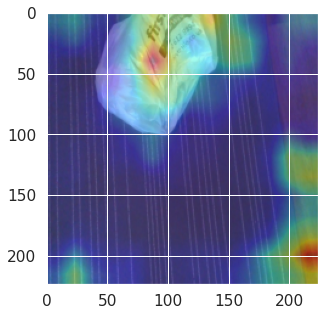

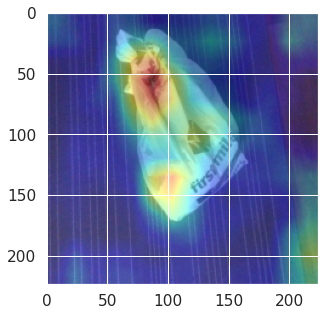

In [206]:
inputs, labels = next(iter(image_loaders["test"]))
inputs = inputs.to(device)
labels = labels.to(device)

for input in inputs:
    tensor = input.unsqueeze(0)
    cam, idx = wrapped_model(tensor)

    show_activations(input.cpu(), cam.squeeze().numpy())

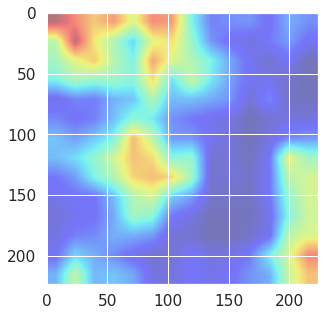

In [170]:
# visualize only cam
plt.imshow(cam.squeeze().numpy(), alpha=0.5, cmap='jet')